# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# colab libraries
from google.colab import drive
from google.colab.patches import cv2_imshow

import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Seeding

In [3]:
torch.manual_seed(784)

In [4]:
np.random.seed(54)

# Data Processing

## Mount Drive

In [5]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
BASE_PATH = '/content/drive/MyDrive/DL Project/Project Dataset'
TRAIN_PATH = BASE_PATH + '/train_unzipped'
TRAIN_LABEL_PATH = BASE_PATH + '/train_label_unzipped'
VAL_PATH = BASE_PATH + '/val_unzipped'
VAL_LABEL_PATH = BASE_PATH + '/val_label_unzipped'

## Load Data

In [7]:
def import_data(INPUT_PATH: str, LABEL_PATH: str, final_dimension: tuple, input_id_index : tuple, label_id_index : tuple, is_val: bool = False):

    inputs = []
    labels = []

    files = os.listdir(INPUT_PATH)
    label_files = os.listdir(LABEL_PATH)

    for index, file in enumerate(files):
        
        if (not is_val) and index % 3 > 0:
            continue

        try:
            idx = (int) (file[ input_id_index[0] : input_id_index[1] ])
        except:
            continue

        image = cv2.imread(INPUT_PATH+"/"+file)
        image = cv2.resize(image, final_dimension)
        inputs.append(image)

        for label_file in label_files:
        
            label_idx = (int)(label_file[ label_id_index[0] : label_id_index[1] ])

            if(idx == label_idx):
                label_image = cv2.imread(LABEL_PATH+"/"+label_file)
                label_image = cv2.resize(label_image, final_dimension)
                labels.append(label_image)
                break

    inputs = np.array(inputs)
    inputs = inputs/255
    labels = np.array(labels)
    labels = labels/255

    return (inputs, labels)

In [8]:
reduced_dims = (192, 96)

In [9]:
# the below 4 variables denotes the idx indices for the file names

train_input_id_index = (44, -4)   # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png
train_label_id_index = (44, -10)  # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png

val_input_id_index = (44, -19)    # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set.png
val_label_id_index = (44, -25)    # Example: Town04_Clear_Noon_09_09_2020_14_57_22_frame_100_validation_set_label.png

In [10]:
train_x, train_y = import_data(TRAIN_PATH, TRAIN_LABEL_PATH, reduced_dims, train_input_id_index, train_label_id_index)
val_x, val_y = import_data(VAL_PATH, VAL_LABEL_PATH, reduced_dims, val_input_id_index, val_label_id_index, True)

In [11]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

(1026, 96, 192, 3) (1026, 96, 192, 3)
(129, 96, 192, 3) (129, 96, 192, 3)


## Data Visualising

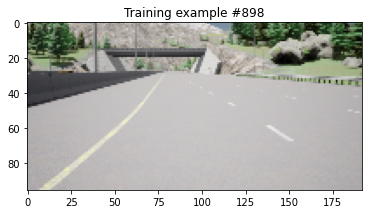

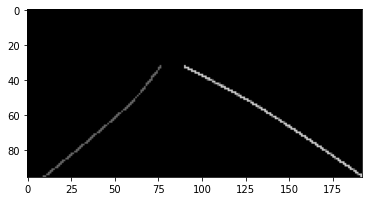

In [12]:
i = np.random.randint(0, len(train_x))
plt.imshow(train_x[i])
plt.title(f"Training example #{i}")
plt.show()
plt.imshow(train_y[i]*100)
plt.show()

# Model Architecture

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class OneOne(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OneOne, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, x):
        return self.conv(x)

class NeuralNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, c=32, features=[16, 32, 64, 128],
    ):
        super(NeuralNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.bottlenecks = nn.ModuleList()
        self.finalconvs = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of NeuralNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # bottleneck
        self.bottlenecks.append(DoubleConv(features[-1], features[-1]*2))       # 256 channels
        self.bottlenecks.append(OneOne(features[-1]*2, c))                      # c channels 

        # Up part of NeuralNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    c, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature, feature))
            self.ups.append(OneOne(feature, c))

        # final task specific
        self.finalconvs.append(OneOne(c, 32))
        self.finalconvs.append(OneOne(32, 7))
        self.finalconvs.append(nn.Softmax2d())

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        for bottleneck in self.bottlenecks:
            x = bottleneck(x)
        
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 3):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//3]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            # concat_skip = torch.cat((skip_connection, x), dim=1)

            concat_skip = x + skip_connection
            x = self.ups[idx+1](concat_skip)
            x = self.ups[idx+2](x)
        
        for final_conv in self.finalconvs:
            x = final_conv(x)

        return x

#### Model Summary

In [14]:
input_dim = (3, 96, 192)

In [15]:
from torchsummary import summary
testing_model = NeuralNet()

# while working on GPU
summary(testing_model.cuda(), input_dim)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 96, 192]             432
       BatchNorm2d-2          [-1, 16, 96, 192]              32
              ReLU-3          [-1, 16, 96, 192]               0
            Conv2d-4          [-1, 16, 96, 192]           2,304
       BatchNorm2d-5          [-1, 16, 96, 192]              32
              ReLU-6          [-1, 16, 96, 192]               0
        DoubleConv-7          [-1, 16, 96, 192]               0
         MaxPool2d-8           [-1, 16, 48, 96]               0
            Conv2d-9           [-1, 32, 48, 96]           4,608
      BatchNorm2d-10           [-1, 32, 48, 96]              64
             ReLU-11           [-1, 32, 48, 96]               0
           Conv2d-12           [-1, 32, 48, 96]           9,216
      BatchNorm2d-13           [-1, 32, 48, 96]              64
             ReLU-14           [-1, 32,

# Ground 

## Train Preprocessing

In [16]:
n, h, w, c = train_y.shape          # 1026 x 96 x 192 x 3
shape_ground = (n, h, w, 7)

In [17]:
ground = np.zeros(shape=shape_ground)   # 1026 x 96 x 192 x 7
back_ground_limit = 0.0

In [18]:
def dfs(y, i, row, col, id):

    #overflow
    if row >= h or col >= w or col<0 or row<0:
      return

    if ground[i][row][col][id]>0:
        return

    if y[row][col][0] <= back_ground_limit and y[row][col][1] <= back_ground_limit and y[row][col][2] <= back_ground_limit:
      return

    ground[i][row][col][id] = 1

    #search for neighbours
    dfs(y, i, row-1, col, id)
    dfs(y, i, row+1, col, id)
    dfs(y, i, row, col-1, id)
    dfs(y, i, row, col+1, id)
    dfs(y, i, row+1, col+1, id)
    dfs(y, i, row+1, col-1, id)
    dfs(y, i, row-1, col-1, id)
    dfs(y, i, row-1, col+1, id)
    return

def get_ground(y, i):
    h, w, _ = y.shape
    key = 1

    for r in range(h):
        for c in range(w):
            if y[r][c][0] <= back_ground_limit and y[r][c][1] <= back_ground_limit and y[r][c][2] <= back_ground_limit:
                ground[i][r][c][0] = 1
                continue
            elif np.sum(ground[i][r][c]) > 0:
                continue
            else:
                dfs(y, i, r, c, key)
                key+=1

    return

def get_ground_for_each_train(y_train):
    n, h, w, c = y_train.shape          # 1026 x 96 x 192 x 3
    for i in range(n):
        get_ground(y_train[i], i)
    return 

In [19]:
get_ground_for_each_train(train_y)

In [20]:
ground.shape

(1026, 96, 192, 7)

## Validation Preprocessing

In [21]:
n, h, w, c = val_y.shape          # 1026 x 96 x 192 x 3
shape_val = (n, h, w, 7)

In [22]:
val_ground = np.zeros(shape=shape_val)

In [23]:
def dfs(y, i, row, col, id):

    #overflow
    if row >= h or col >= w or col<0 or row<0:
      return

    if val_ground[i][row][col][id]>0:
        return

    if y[row][col][0] <= back_ground_limit and y[row][col][1] <= back_ground_limit and y[row][col][2] <= back_ground_limit:
      return

    val_ground[i][row][col][id] = 1

    #search for neighbours
    dfs(y, i, row-1, col, id)
    dfs(y, i, row+1, col, id)
    dfs(y, i, row, col-1, id)
    dfs(y, i, row, col+1, id)
    dfs(y, i, row+1, col+1, id)
    dfs(y, i, row+1, col-1, id)
    dfs(y, i, row-1, col-1, id)
    dfs(y, i, row-1, col+1, id)
    return

def get_ground_val(y, i):
    h, w, _ = y.shape
    key = 1

    for r in range(h):
        for c in range(w):
            if y[r][c][0] <= back_ground_limit and y[r][c][1] <= back_ground_limit and y[r][c][2] <= back_ground_limit:
                val_ground[i][r][c][0] = 1
                continue
            elif np.sum(val_ground[i][r][c]) > 0:
                continue
            else:
                dfs(y, i, r, c, key)
                key+=1

    return

def get_ground_for_each_val(y_test):
    n, h, w, c = y_test.shape          # 1026 x 96 x 192 x 3
    for i in range(n):
        g = get_ground_val(y_test[i], i)
    return 

In [24]:
get_ground_for_each_val(val_y)

In [25]:
val_ground.shape

(129, 96, 192, 7)

# Loss Function

#### IoU Loss

In [26]:
class IoULoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, epsilon=1e-6):
        super(IoULoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon

    def forward(self, targets, inputs):
        # batch_size x 7 x 96 x 192
        t = torch.zeros(7)

        for i in range(7):

            #flatten label and prediction tensors
            ip = torch.flatten(inputs[:, i, :, :])
            tg = torch.flatten(targets[:, i, :, :])
            
            #True Positives, False Positives & False Negatives
            TP = torch.sum(tg * ip)
            FP = torch.sum((1-tg) * ip)
            FN = torch.sum(tg * (1-ip))  # wrong lanes 
            
            iou = (TP + self.epsilon) / (TP + self.alpha*FP + self.beta*FN + self.epsilon) 
            t[i] = 1-iou

        return torch.sum(t)

# Learning

#### Hyperparameters

In [27]:
lr = 0.01
batch_size = 8
momentum = 0.2
epochs = 100
ALPHA = 0.5
BETA = 0.5
epsilon = 1e-6

#### Shapes

In [28]:
print(train_x.shape , train_y.shape)

(1026, 96, 192, 3) (1026, 96, 192, 3)


In [29]:
print(val_x.shape, val_y.shape)

(129, 96, 192, 3) (129, 96, 192, 3)


In [30]:
print(ground.shape)

(1026, 96, 192, 7)


In [31]:
print(val_ground.shape)

(129, 96, 192, 7)


#### Model Initialisation

In [32]:
model = NeuralNet().to(device)

#### Optimizer

In [33]:
optimizer = optim.Adam(model.parameters(), lr, eps=epsilon)

#### Loss Class

In [34]:
iou_loss = IoULoss(alpha=ALPHA, beta=BETA, epsilon=epsilon)

#### Weight Initializer

In [35]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, 1)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 0, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0, 1)
        nn.init.constant_(m.bias.data, 0)

#### Training and Validation

In [36]:
train_losses = []
validation_losses = []

In [37]:
model.train()
model.apply(initialize_weights)

n = len(train_x)

for epoch in range(epochs):

    train_loss = 0.0

    for i in range( n//batch_size ):

        optimizer.zero_grad()

        ip = torch.from_numpy(train_x[i*batch_size: i*batch_size+batch_size]).float()
        ip = ip.to(device)

        # changing from batch_size x 96 x 192 x 3 to batch_size x 3 x 96 x 192
        ip = ip.transpose(1, 3)
        ip = ip.transpose(2, 3)

        # batch_size x 96 x 192 x 7
        gt = torch.from_numpy(ground[i*batch_size: i*batch_size+batch_size]).float()
        gt = gt.to(device)

        # changing from batch_size x 96 x 192 x 7 to batch_size x 7 x 96 x 192
        gt = gt.transpose(1, 3)
        gt = gt.transpose(2, 3)

        # forward
        op = model(ip)                  # batch_size x 7 x 96 x 192
        loss = iou_loss(gt, op)

        # backward
        loss.backward()
        optimizer.step()
    
        # update losses
        train_loss += loss.item()

    print("Loss after epoch " + str(epoch) + " is : " + str(loss.item()))
    train_losses.append(train_loss)


Loss after epoch 0 is : 6.006418228149414
Loss after epoch 1 is : 5.423964500427246
Loss after epoch 2 is : 5.313560485839844
Loss after epoch 3 is : 5.229580402374268
Loss after epoch 4 is : 5.143327713012695
Loss after epoch 5 is : 5.099689960479736
Loss after epoch 6 is : 5.05098819732666
Loss after epoch 7 is : 5.062687397003174
Loss after epoch 8 is : 5.040078163146973
Loss after epoch 9 is : 5.004097938537598
Loss after epoch 10 is : 5.061997890472412
Loss after epoch 11 is : 4.993066787719727
Loss after epoch 12 is : 4.9800262451171875
Loss after epoch 13 is : 4.971951484680176
Loss after epoch 14 is : 5.002190589904785
Loss after epoch 15 is : 5.003393173217773
Loss after epoch 16 is : 4.983246803283691
Loss after epoch 17 is : 5.053338527679443
Loss after epoch 18 is : 4.95598030090332
Loss after epoch 19 is : 4.985470771789551
Loss after epoch 20 is : 5.011405944824219
Loss after epoch 21 is : 4.97827672958374
Loss after epoch 22 is : 4.978200435638428
Loss after epoch 23 is 

In [38]:
validation_accuracy = []

In [39]:
model.eval()

num_correct = 0.0
num_pixels = 0.0

m = len(val_x)
_, h, w, _ = ground.shape

with torch.no_grad():
    for i in range(m):

        input = torch.from_numpy(val_x[i]).float()
        input = torch.unsqueeze(input, axis = 0)
        input = input.to(device)

        # # changing from 1 x 96 x 192 x 7 to 1 x 7 x 96 x 192
        input = input.transpose(1, 3)
        input = input.transpose(2, 3)

        # 1 x 7 x 96 x 192
        output = torch.from_numpy(val_ground[i]).float()
        output = torch.unsqueeze(output, axis = 0)
        output = output.to(device)

        output = output.transpose(1, 3)
        output = output.transpose(2, 3)

        predictions = model(input)

        loss = iou_loss(predictions, output)
        validation_losses.append(loss.item())

        output = 1 - output[:, 0:1, :, :]
        predictions = 1 - torch.where(predictions[:, 0:1, :, :] >= 0.5, 1, 0)

        num_correct = (predictions == output).type(torch.float).sum().item()
        num_pixels = (float) (h*w)

        validation_accuracy.append((num_correct / num_pixels))
        
        print("# of White : " + str((output != 0).sum().item()) + ", # of Black : " + str((output == 0).sum().item()))
        print("Correctly Predicted : " + str(num_correct) + ", Wrongly Predicted : " + str(num_pixels - num_correct))

        print("Accuracy for validation Sample " + str(i) + " is :" + str(num_correct / num_pixels))

# of White : 264, # of Black : 18168
Correctly Predicted : 18283.0, Wrongly Predicted : 149.0
Accuracy for validation Sample 0 is :0.9919162326388888
# of White : 307, # of Black : 18125
Correctly Predicted : 18313.0, Wrongly Predicted : 119.0
Accuracy for validation Sample 1 is :0.9935438368055556
# of White : 258, # of Black : 18174
Correctly Predicted : 18312.0, Wrongly Predicted : 120.0
Accuracy for validation Sample 2 is :0.9934895833333334
# of White : 282, # of Black : 18150
Correctly Predicted : 18372.0, Wrongly Predicted : 60.0
Accuracy for validation Sample 3 is :0.9967447916666666
# of White : 287, # of Black : 18145
Correctly Predicted : 18369.0, Wrongly Predicted : 63.0
Accuracy for validation Sample 4 is :0.99658203125
# of White : 294, # of Black : 18138
Correctly Predicted : 18294.0, Wrongly Predicted : 138.0
Accuracy for validation Sample 5 is :0.9925130208333334
# of White : 242, # of Black : 18190
Correctly Predicted : 18297.0, Wrongly Predicted : 135.0
Accuracy for 

# Loss Trend

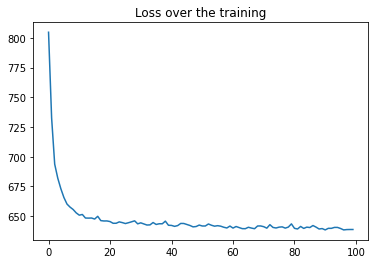

In [40]:
plt.title(f"Loss over the training")
plt.plot(train_losses)
plt.show()

In [41]:
print("Validation Loss : " + str(sum(validation_losses)/len(validation_losses)))

Validation Loss : 5.0118089350619055


In [42]:
print("Validation Accuracy : " + str(sum(validation_accuracy)/len(validation_accuracy)))

Validation Accuracy : 0.9950259239071914


# Ouput Visualisation

In [43]:
sample_number = np.random.randint(129)

#### Process

In [44]:
with torch.no_grad():
    input = torch.from_numpy(val_x[sample_number]).float()
    input = torch.unsqueeze(input, axis = 0)
    input = input.to(device)

    # # changing from 1 x 96 x 192 x 7 to 1 x 7 x 96 x 192
    input = input.transpose(1, 3)
    input = input.transpose(2, 3)

    # 1 x 7 x 96 x 192
    output = torch.from_numpy(val_ground[sample_number]).float()
    output = torch.unsqueeze(output, axis = 0)
    output = output.to(device)

    output = output.transpose(1, 3)
    output = output.transpose(2, 3)

    predictions = model(input)

    loss = iou_loss(predictions, output)
    validation_losses.append(loss.item())

    output = 1 - output[:, 0:1, :, :]
    predictions = 1 - torch.where(predictions[:, 0:1, :, :] >= 0.5, 1, 0)

    num_correct = (predictions == output).type(torch.float).sum().item()
    num_pixels = (float) (h*w)

    print("# of White : " + str((output != 0).sum().item()) + ", # of Black : " + str((output == 0).sum().item()))
    print("Correctly Predicted : " + str(num_correct) + ", Wrongly Predicted : " + str(num_pixels - num_correct))

    print("Accuracy for validation Sample " + str(i) + " is :" + str(num_correct / num_pixels))

# of White : 253, # of Black : 18179
Correctly Predicted : 18387.0, Wrongly Predicted : 45.0
Accuracy for validation Sample 128 is :0.99755859375


#### Visuals

In [45]:
broad_caster = np.ones(shape=(96, 192, 3))

<Figure size 432x288 with 0 Axes>

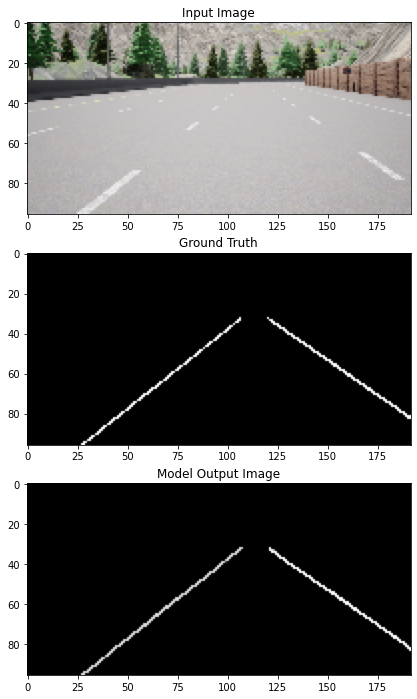

In [46]:
with torch.no_grad():
    ip = torch.from_numpy(val_x[sample_number]).float()
    ip = torch.unsqueeze(ip, axis = 0)
    ip = ip.to(device)

    # changing from  x 96 x 192 x 7 to 1 x 7 x 96 x 192
    ip = ip.transpose(1, 3)
    ip = ip.transpose(2, 3)

    # 1x 7 x 96 x 192
    y_pred = model(ip)

    # 1 x 96 x 192 x 7
    y_pred = y_pred.transpose(1, 2)
    y_pred = y_pred.transpose(2, 3)

    # 96 x 192 x 7
    y_pred = y_pred[0, :, :, :]

    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()

    plt.figure()
    f, axarr = plt.subplots(3,1, figsize=(17, 12))

    axarr[0].title.set_text("Input Image")
    axarr[0].imshow(val_x[sample_number])
    
    axarr[1].title.set_text("Ground Truth")
    axarr[1].imshow((1 - val_ground[sample_number][:, :, 0:1])*broad_caster)

    axarr[2].title.set_text("Model Output Image")
    axarr[2].imshow((1 - y_pred[:, :, 0:1])*broad_caster)

#### Instances

In [47]:
# instance color 
rgb = [
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]
]
rgb = np.array(rgb)

<Figure size 432x288 with 0 Axes>

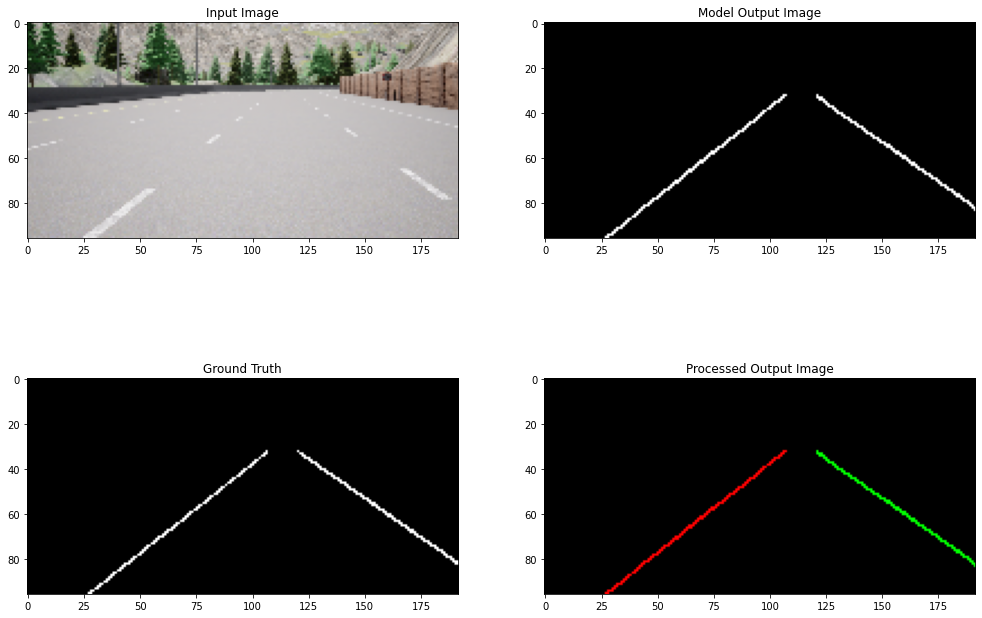

In [48]:
# instance print
with torch.no_grad():
    ip = torch.from_numpy(val_x[sample_number]).float()
    ip = torch.unsqueeze(ip, axis = 0)
    ip = ip.to(device)

    # changing from  1 x 96 x 192 x 7 to 1 x 7 x 96 x 192
    ip = ip.transpose(1, 3)
    ip = ip.transpose(2, 3)

    # 1x 7 x 96 x 192
    y_pred = model(ip)

    # 1 x 96 x 192 x 7
    y_pred = y_pred.transpose(1, 2)
    y_pred = y_pred.transpose(2, 3)

    # 96 x 192 x 7
    y_pred = y_pred[0, :, :, :]

    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()

    # get instance
    y_pred_com= np.zeros(shape=(96, 192, 1))
    for i in range(96):
        for j in range(192):
            if(y_pred[i][j][0] < 0.5):
                mx = 0
                jd = 0
                for d in range(1,7):
                    if y_pred[i][j][d]>mx:
                        jd=d
                        mx=y_pred[i][j][d]
                y_pred_com[i][j][0] = jd
    
    final_pred = np.zeros(shape=(96, 192, 3))
    for i in range(96):
        for j in range(192):
            tmp = (int) (y_pred_com[i][j][0])
            final_pred[i][j] = rgb[tmp]

    plt.figure()
    f, axarr = plt.subplots(2,2, figsize=(17, 12)) 

    axarr[0][0].title.set_text("Input Image")
    axarr[0][0].imshow(val_x[sample_number])

    axarr[0][1].title.set_text("Model Output Image")
    axarr[0][1].imshow(np.where(y_pred_com[:, :, 0:1] == 0, 0, 1) * broad_caster)
    
    axarr[1][0].title.set_text("Ground Truth")
    axarr[1][0].imshow((1 - val_ground[sample_number][:, :, 0:1])*broad_caster)
    
    axarr[1][1].title.set_text("Processed Output Image")
    axarr[1][1].imshow(final_pred)